In [ ]:
!pip install folium
!pip install quilt
!pip install missingno
!pip install plotly

In [58]:
import missingno as msno
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from IPython.display import display
%matplotlib inline

from sklearn.base import TransformerMixin
from sklearn.preprocessing import Imputer
import sklearn
import numpy as np
import pandas as pd

import os
import time
import json
import numba
import folium

In [3]:
class DataFrameImputer(TransformerMixin):

    def __init__(self):
        """Impute missing values.

        Columns of dtype object are imputed with the most frequent value 
        in column.

        Columns of other types are imputed with mean of column.

        """

    def fit(self, X, y=None):
        self.fill = pd.Series([X[c].value_counts().index[0] if X[c].dtype == np.dtype('O') else X[c].mean() for c in X], index=X.columns)

        return self
    
    def transform(self, X, y=None):
        return X.fillna(self.fill)

In [4]:
df_courses = pd.read_json('/Users/vml/estagiario_pd/datasets/courses.json', orient='records')
df_sessions = pd.read_json('/Users/vml/estagiario_pd/datasets/sessions.json', orient='records')
df_sfs = pd.read_json('/Users/vml/estagiario_pd/datasets/student_follow_subject.json', orient='records')
df_students = pd.read_json('/Users/vml/estagiario_pd/datasets/students.json', orient='records')
df_subjects = pd.read_json('/Users/vml/estagiario_pd/datasets/subjects.json', orient='records')
df_subscriptions = pd.read_json('/Users/vml/estagiario_pd/datasets/subscriptions.json', orient='records')
df_universities = pd.read_json('/Users/vml/estagiario_pd/datasets/universities.json', orient='records')

In [5]:
df_students = df_students[['Id', 'CourseId', 'UniversityId', 'State', 'City', 'RegisteredDate', 'StudentClient', 'SignupSource']]
df_sfs = df_sfs[['StudentId', 'SubjectId', 'FollowDate']]
df_subscriptions = df_subscriptions[['StudentId', 'PlanType', 'PaymentDate']]
df_sessions = df_sessions[['StudentId', 'SessionStartTime', 'StudentClient']]

In [ ]:
#converter todas as colunas categoricas para category data type pra economizar memória

df_students["Id"] = df_students["Id"].astype('category')

In [6]:
def create_id_to_name():
    for name in ("subjects","courses","universities"):
        LOC = f"""
global change_id_to_name_{name}
change_id_to_name_{name} = df_{name}.set_index('Id').to_dict()['Name']
"""
        exec(LOC)

def replace_all_id_to_name():
    for name in ("subjects","courses","universities"):
        if name == "subjects":
            df_sfs.SubjectId.replace(change_id_to_name_subjects, inplace = True)
        elif name == "courses":
            df_students.CourseId.replace(change_id_to_name_courses, inplace = True)
        elif name == "universities":
            df_students.UniversityId.replace(change_id_to_name_universities,inplace = True)

def time_tuple_conversion(df):
    # para análise de séries temporais, pode ser que ajude, não sei o padrão de uso
    for date in ("RegisteredDate", "PaymentDate", "FollowDate", "SessionStartTime"):
        try:
            if date in df.columns:
                df[date] = df[date].apply(lambda x: x[:19]).apply(time.strptime, args=["%Y-%m-%d %H:%M:%S"]).apply(lambda x: x[:6])
        except:
            print(f"Provavelmente já foi convertida a coluna {date}")
            pass
            
            
create_id_to_name()
replace_all_id_to_name()

In [7]:
# pra evidenciar a necessidade da imputacao de dados

df_students.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60000 entries, 0 to 59999
Data columns (total 8 columns):
Id                60000 non-null object
CourseId          60000 non-null object
UniversityId      60000 non-null object
State             24607 non-null object
City              19753 non-null object
RegisteredDate    60000 non-null object
StudentClient     51541 non-null object
SignupSource      60000 non-null object
dtypes: object(8)
memory usage: 3.7+ MB


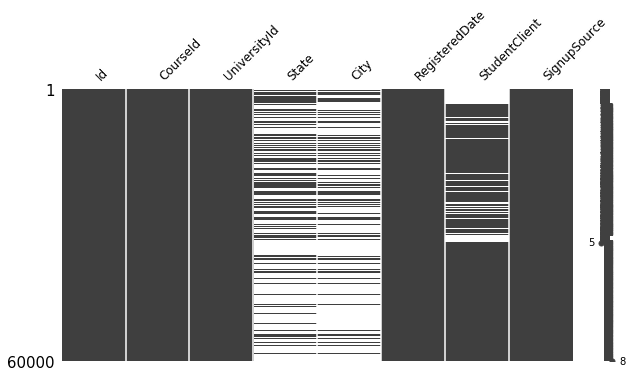

In [10]:
display(msno.matrix(df_students, figsize=(10, 5), width_ratios=(20,1), fontsize=12))

In [8]:
# explicar aqui como usei o simple imputer alterado pra fazer imputacao de dados, e mostrar como é problemático em relação ao viés essa solução, que podem ter soluções
# mais eficientes como fazendo um label enconding pra numéricos aplicar GLRM e reverter, pq GLRM consegue captar os padrões e preencher na tabela
# explicar a minha solução pra manter a consistencia dos dados, pq tava dando Rio de Janeiro de cidade e Minas Gerais de estado em umas imputacoes 

# o ideal era fazer sobre head(200)

top20_universidades = tuple(df_students.UniversityId.value_counts().head(20).index.values)

dados_pra_imputar = df_students[["UniversityId","State","City"]]
df_teste = dados_pra_imputar

def imputando_dados_faltantes(df_test, universidades):
    
    na_na = df_test[(df_test['State'].isna()) & (df_test['City'].isna())]
    n_na_na = df_test[(df_test['State'].notnull()) & (df_test['City'].isna())]
    na_n_na = df_test[(df_test['State'].isna()) & (df_test['City'].notnull())]
    filled = df_test[(df_test['State'].notnull()) & (df_test['City'].notnull())]
    
    f_n_na_na = pd.concat([filled,n_na_na]).drop_duplicates().reset_index(drop=True)
    f_na_n_na = pd.concat([filled,na_n_na]).drop_duplicates().reset_index(drop=True)
    f_na_na = pd.concat([filled,na_na]).drop_duplicates().reset_index(drop=True)
    
    estados = tuple(df_test.State.value_counts().index)
    cidades = tuple(df_test.City.value_counts().index)
    
    
    for univ in universidades:
        t0 = time.time()
        for estado in estados:
                try:
                    df_test = df_test.combine_first(DataFrameImputer().fit_transform(f_n_na_na[(f_n_na_na["UniversityId"]==univ) & (f_n_na_na["State"]==estado)]))
                except:
                    pass
        t1= time.time()
        print('1. ',t1-t0," segundos")

        t0 = time.time()
        for cidade in cidades:
                try:
                    na_n_na = df_test[(df_test['State'].isna()) & (df_test['City'].notnull())]
                    filled = df_test[(df_test['State'].notnull()) & (df_test['City'].notnull())]
                    f_na_n_na = pd.concat([filled,na_n_na]).drop_duplicates().reset_index(drop=True).to_numpy()
                    
                    df_test = df_test.combine_first(DataFrameImputer().fit_transform(f_na_n_na[(f_na_n_na["UniversityId"]==univ) & (f_na_n_na["City"]==cidade)]))
                except:
                    pass
        t1= time.time()
        print('2. ',t1-t0," segundos")
        
        t0 = time.time()
        try:
            na_na = df_test[(df_test['State'].isna()) & (df_test['City'].isna())]
            filled = df_test[(df_test['State'].notnull()) & (df_test['City'].notnull())]
            f_na_na = pd.concat([filled,na_na]).drop_duplicates().reset_index(drop=True)
            
            df_test = df_test.combine_first(DataFrameImputer().fit_transform(f_na_na[f_na_na["UniversityId"]==univ]))
        except:
            pass
        t1= time.time()
        print('3. ',t1-t0," segundos")
    
    return df_test
        
df_students[["UniversityId","State","City"]] = imputando_dados_faltantes(df_teste, top20_universidades)

1.  1.6881420612335205  segundos
2.  53.24144697189331  segundos
3.  0.10339999198913574  segundos
1.  1.4820199012756348  segundos
2.  51.67724680900574  segundos
3.  0.10083723068237305  segundos
1.  1.3336009979248047  segundos
2.  53.3731369972229  segundos
3.  0.10266494750976562  segundos
1.  1.444331169128418  segundos
2.  52.94799089431763  segundos
3.  0.10469198226928711  segundos
1.  1.2746379375457764  segundos
2.  53.51690888404846  segundos
3.  0.10368990898132324  segundos
1.  1.237687110900879  segundos
2.  54.01789999008179  segundos
3.  0.10658526420593262  segundos
1.  1.1726818084716797  segundos
2.  52.909342765808105  segundos
3.  0.10341095924377441  segundos
1.  0.7786350250244141  segundos
2.  54.00857496261597  segundos
3.  0.10149717330932617  segundos
1.  0.6676857471466064  segundos
2.  52.37494993209839  segundos
3.  0.08889603614807129  segundos
1.  0.434492826461792  segundos
2.  54.175063133239746  segundos
3.  0.1038517951965332  segundos
1.  0.2455329

In [9]:
# pode ser conveniente montar um classificador de palavras aleatorias em portugues,
# pra avaliar ddaddos no BD que são irrelevantes ou desconsiderar, ou contar quantas pessoas usam essas palavras
# avaliar se sao mesmo aleatoria

In [11]:
df_students.head()

,Id,CourseId,UniversityId,State,City,RegisteredDate,StudentClient,SignupSource
0,0cade9bf00234e3789afc76250e4042bc1b70784ae7004...,Engenharia Elétrica,UERJ,Rio de Janeiro,Rio de Janeiro,2012-09-06 17:27:11.370000,NaN,Facebook
1,8a501cab6c0a5a7e98a86f51a6264d81cdb562f4e99106...,Economia / Ciências Econômicas,UERJ,Rio de Janeiro,Rio de Janeiro,2012-09-05 15:31:08.090000,NaN,Facebook
2,b8a39150d98d746853087a4107e9290976cb6c99d16a29...,Direito,PUC-RIO,NaN,NaN,2012-08-17 10:00:04.270000,NaN,Facebook
3,0f6c90f966a70b84b70ea84a62d2e46ae4a2a237670815...,Ciências Ambientais,UNIRIO,Rio de Janeiro,Rio de Janeiro,2012-10-22 21:16:52.157000,NaN,Facebook
4,388bf84cffb3219384cd7a92153cf00f3b1416e4ff1473...,Engenharia Química,UFSJ,Minas Gerais,NaN,2012-10-24 01:48:53.700000,NaN,Facebook


In [12]:
# descrever no jupyter todos esses databases montados, o por que de cada um e por que separados, o por que ordenei as colunas de cada forma, como pode ajudar a visualizar os dados;
# também ver quais colunas tirar no final da análise

students_subjects = df_sfs.rename(columns = {"StudentId":"Id"}).merge(df_students, on= ["Id"]).rename(
    columns = {"Id":"StudentId", "SubjectId":"SubjectName", "CourseId": "CourseName",
               "UniversityId":"UniversityName" })[
['StudentId', 'CourseName', 'UniversityName', 'RegisteredDate', 'State', 'City', 'SubjectName', 'FollowDate', 'StudentClient', 'SignupSource']];

students_subjects_subscriptions = df_sfs.rename(columns = {"StudentId":"Id"}).merge(df_students, on= ["Id"]).rename(
    columns = {"Id":"StudentId", "SubjectId":"SubjectName", "CourseId": "CourseName",
               "UniversityId":"UniversityName" })[
['StudentId', 'CourseName', 'UniversityName', 'RegisteredDate', 'State', 'City', 'SubjectName', 'FollowDate', 'StudentClient', 'SignupSource']].merge(df_subscriptions, on = ["StudentId"]);

students_sessions = df_sessions.rename(columns = {"StudentId":"Id"}).merge(df_students, on = ["Id"]).rename(
    columns = {"Id":"StudentId","CourseId":"CourseName","UniversityId":"UniversityName"})[['StudentId','CourseName','UniversityName','SessionStartTime','StudentClient_x','StudentClient_y','State','City','RegisteredDate','SignupSource']];

sessions_subscriptions = df_sessions.merge(df_subscriptions, on= ["StudentId"])[['StudentId','SessionStartTime','StudentClient','PaymentDate', 'PlanType']];

students_subscriptions = df_subscriptions.rename(columns = {"StudentId":"Id"}).merge(df_students, on= ["Id"]).rename(
    columns = {"Id":"StudentId", "CourseId": "CourseName",
               "UniversityId":"UniversityName" })[['StudentId', 'UniversityName', 'CourseName', 'PlanType', 'PaymentDate', 'State', 'City', 'RegisteredDate', 'SignupSource', 'StudentClient']];

In [13]:
# tá demorando bem eim... é provavel que eu tenha que comprimir tudo num só dataset, mas vou deixar assim por enquanto

# que facilita a minha vida

for database in (students_subjects, students_subjects_subscriptions, students_sessions, sessions_subscriptions, students_subscriptions):
    time_tuple_conversion(database)

In [14]:
df_students.SignupSource.value_counts() # da pra fazer um histograma aqui

Facebook    30346
Google      19312
Email       10342
Name: SignupSource, dtype: int64

In [15]:
df_students.StudentClient.value_counts().head(7)

Website                     38415
Webapp                       3214
Android | 6.0.1 | sdk 23     2137
Android | 7.0 | sdk 24       1059
Android | 6.0 | sdk 23       1045
Android | 5.1.1 | sdk 22      646
Android | 4.4.4 | sdk 19      434
Name: StudentClient, dtype: int64

In [16]:
df_students.UniversityId.value_counts().head(5)

ESTÁCIO        9030
UNIP           4426
UNOPAR         1857
UNINTER        1856
ESTÁCIO EAD    1478
Name: UniversityId, dtype: int64

In [17]:
df_students.CourseId.value_counts().head(5)

Direito                               9916
Administração                         4168
Engenharia Civil                      3562
Contabilidade / Ciências Contábeis    2714
Pedagogia                             2566
Name: CourseId, dtype: int64

In [18]:
df_subscriptions.head(10)

,StudentId,PlanType,PaymentDate
0,29037b0a52c5b576d32ac5842fd5b7e5991c5bef93150f...,Mensal,2017-11-14 19:52:36.756325
1,b2bace77d15c3dfaf57bf9916f0e9924d12f89bdc0624c...,Mensal,2017-11-08 11:52:09.830538
2,f423d6fe2f8964db634c7806e03b0f6567e992e994f06f...,Mensal,2017-11-05 21:27:47.793878
3,55ccbe518d2edbbd527eddca1431c7f7f3a4676bdbee38...,Mensal,2017-11-15 14:36:42.348867
4,b1b0f63fe3e4820cb082531af7c8911cd380e5ec8fe822...,Mensal,2017-11-12 22:19:54.575387
5,ed46832f6b716fb2e2f6f11b43965f2e0a3f2f8f8994ce...,Mensal,2017-11-22 01:03:09.059587
6,69b7bee32821cf76b9ffd5deffca1a01c95499cea24a45...,Mensal,2017-11-24 19:03:49.902349
7,6553923125fe6364e16aacf5656426809bb134b005f182...,Mensal,2017-11-11 21:01:59.149344
8,3903a334d1af8ce838bc2b7f497f11c40437573c1ad30b...,Mensal,2017-11-12 16:41:19.995949
9,4487f81a4ea9b3c3cf58aa31ecc21c30d6fb186993af61...,Mensal,2017-11-21 11:52:55.082745


In [19]:
print(df_students.City.value_counts().head(10),"\n")
print(df_students.State.value_counts().head(10))

Rio de Janeiro    2415
São Paulo         1089
Salvador           667
Belo Horizonte     552
Fortaleza          488
Curitiba           433
Recife             431
Goiânia            396
Brasília           287
São Luís           280
Name: City, dtype: int64 

Rio de Janeiro       5168
São Paulo            3870
Minas Gerais         2417
Paraná               1438
Bahia                1354
Ceará                1236
Rio Grande do Sul    1192
Pernambuco            954
Santa Catarina        876
Goiás                 815
Name: State, dtype: int64


In [20]:
df_sfs.SubjectId.value_counts().head(5)

Bioquímica                4223
Cálculo I                 4053
Anatomia Humana           3950
Direito Constitucional    3926
Matemática Financeira     3405
Name: SubjectId, dtype: int64

In [22]:
df_students.UniversityId.value_counts().head(5)

ESTÁCIO        9030
UNIP           4426
UNOPAR         1857
UNINTER        1856
ESTÁCIO EAD    1478
Name: UniversityId, dtype: int64

In [28]:
students_subjects_subscriptions.head(5)

,StudentId,CourseName,UniversityName,RegisteredDate,State,City,SubjectName,FollowDate,StudentClient,SignupSource,PlanType,PaymentDate
0,29037b0a52c5b576d32ac5842fd5b7e5991c5bef93150f...,Administração,ESTÁCIO EAD,"(2012, 10, 30, 17, 2, 8)",Minas Gerais,Poços de Caldas,Administração de Recursos Humanos,"(2017, 11, 12, 11, 33, 42)",NaN,Email,Mensal,"(2017, 11, 14, 19, 52, 36)"
1,29037b0a52c5b576d32ac5842fd5b7e5991c5bef93150f...,Administração,ESTÁCIO EAD,"(2012, 10, 30, 17, 2, 8)",Minas Gerais,Poços de Caldas,Gestão da Cadeia de Suprimentos,"(2017, 11, 12, 11, 33, 42)",NaN,Email,Mensal,"(2017, 11, 14, 19, 52, 36)"
2,29037b0a52c5b576d32ac5842fd5b7e5991c5bef93150f...,Administração,ESTÁCIO EAD,"(2012, 10, 30, 17, 2, 8)",Minas Gerais,Poços de Caldas,Gestão Financeira de Pequenas e Médias Empresas,"(2017, 11, 12, 11, 33, 42)",NaN,Email,Mensal,"(2017, 11, 14, 19, 52, 36)"
3,29037b0a52c5b576d32ac5842fd5b7e5991c5bef93150f...,Administração,ESTÁCIO EAD,"(2012, 10, 30, 17, 2, 8)",Minas Gerais,Poços de Caldas,Constituição e Legalização de Pequenas e Média...,"(2017, 11, 12, 11, 33, 42)",NaN,Email,Mensal,"(2017, 11, 14, 19, 52, 36)"
4,29037b0a52c5b576d32ac5842fd5b7e5991c5bef93150f...,Administração,ESTÁCIO EAD,"(2012, 10, 30, 17, 2, 8)",Minas Gerais,Poços de Caldas,Administração de Novos Negócios Av1 A Av5,"(2017, 11, 12, 11, 33, 42)",NaN,Email,Mensal,"(2017, 11, 14, 19, 52, 36)"


In [37]:
# Pergunta 1: Quais são os 5 maiores cursos do Passei Direto?

df_students.CourseId.value_counts().head(5)

Direito                               9916
Administração                         4168
Engenharia Civil                      3562
Contabilidade / Ciências Contábeis    2714
Pedagogia                             2566
Name: CourseId, dtype: int64

In [66]:
# Pergunta 2: Quais são as 3 universidades com mais acessos dos usuários premium?

plan_session = df_subscriptions.set_index("StudentId").join(df_sessions.groupby("StudentId").count())[["PlanType","SessionStartTime"]]
plan_session.merge(df_students.rename(columns = {"Id":"StudentId"}), on = ["StudentId"]).UniversityId.value_counts().head(3)

ESTÁCIO        359
ESTÁCIO EAD     85
UNINTER         72
Name: UniversityId, dtype: int64

In [78]:
# Pergunta 3: Quais outras métricas presentes na base de dados podem acrescentar informações importantes para o negócio?
#             Quais insights essas métricas podem trazer para o PD?

#Opcional 4: Quais os assuntos mais consumidos?

students_subjects.SubjectName.value_counts().head(15)

Bioquímica                          4223
Cálculo I                           4053
Anatomia Humana                     3950
Direito Constitucional              3926
Matemática Financeira               3405
Física I                            3023
Direito Penal I                     2956
Fisiologia Humana                   2906
Direito Constitucional I            2857
Direito Processual Civil I          2574
Cálculo II                          2537
Cálculo Diferencial e Integral I    2457
Resistência dos Materiais           2365
Genética                            2275
Farmacologia                        2240
Name: SubjectName, dtype: int64

In [77]:
students_subjects.CourseName.value_counts().head(10)

Direito                               52820
Administração                         20763
Engenharia Civil                      18695
Contabilidade / Ciências Contábeis    13686
Pedagogia                             13448
Psicologia                            11692
Enfermagem                            10928
Medicina                               9216
Fisioterapia                           8328
Engenharia Mecânica                    7837
Name: CourseName, dtype: int64

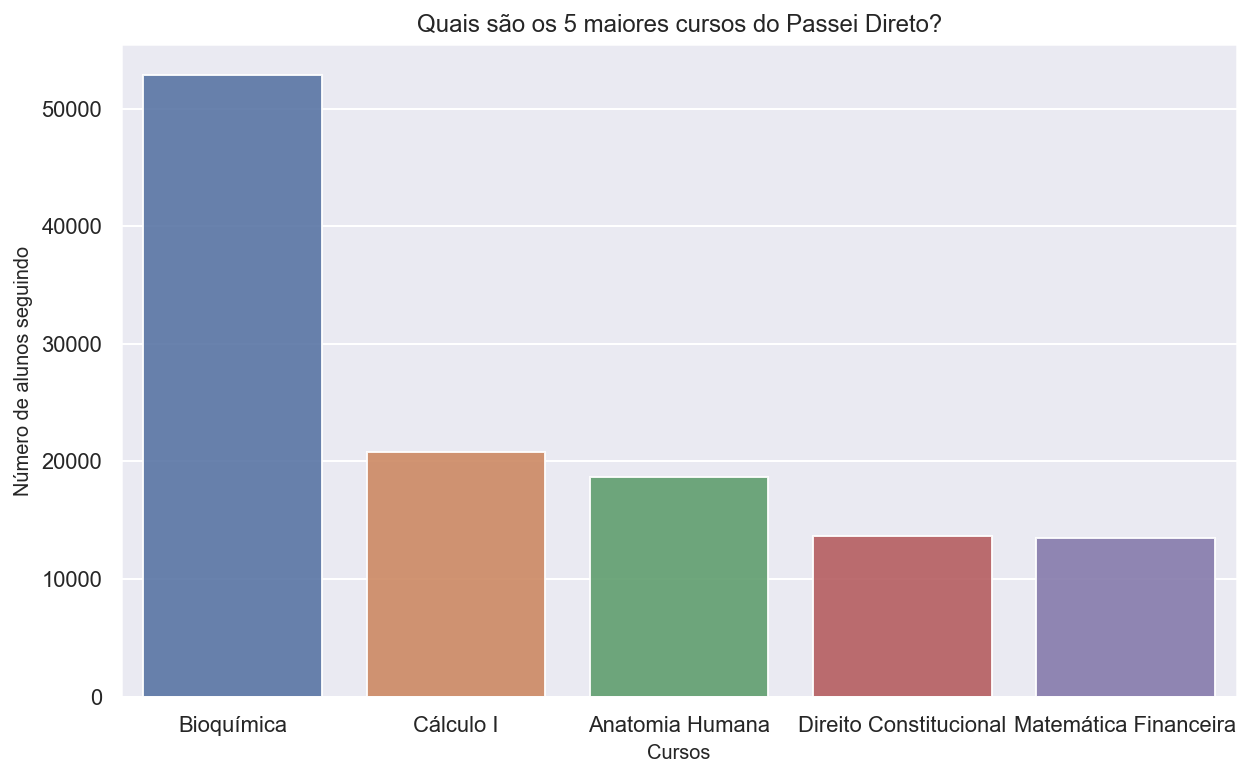

In [36]:


sns.set(style="darkgrid",rc={'figure.figsize':(10,6)})
sns.barplot(students_subjects.SubjectName.value_counts().head(5).index, students_subjects.CourseName.value_counts().head(5).values, alpha=0.9)
plt.title('Quais são os 5 maiores cursos do Passei Direto?')
plt.ylabel('Número de alunos seguindo', fontsize=10)
plt.xlabel('Cursos', fontsize=10)
plt.show()


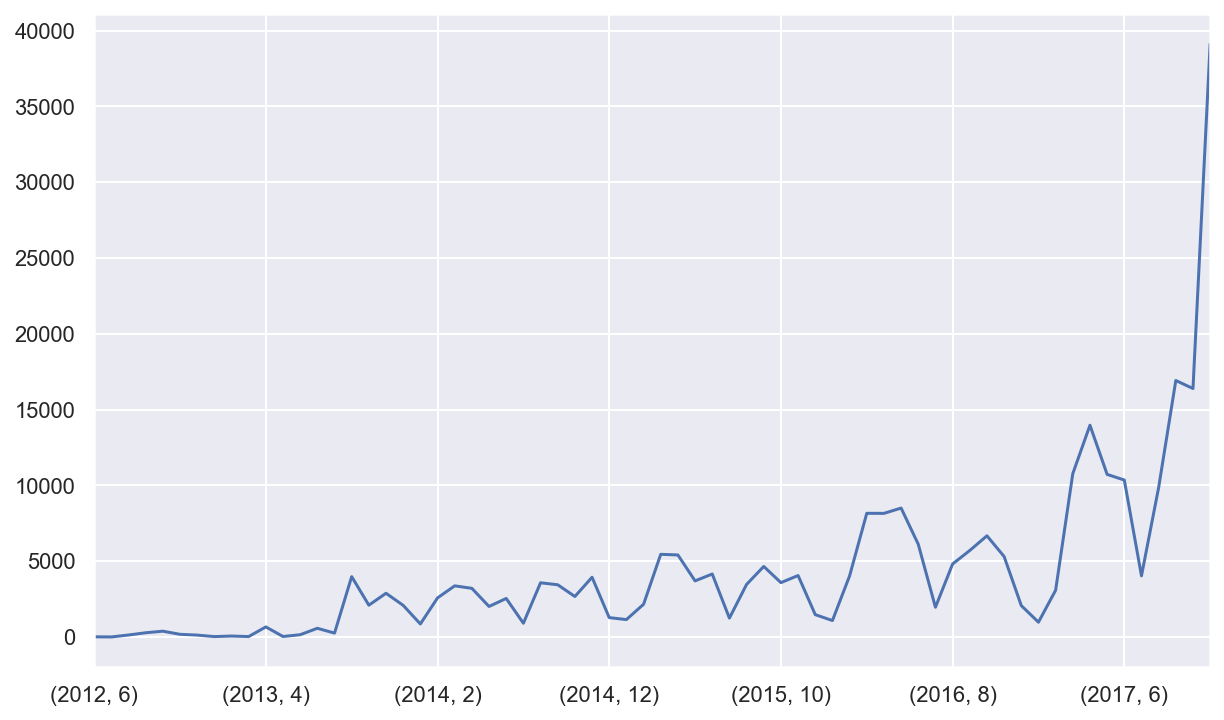

In [37]:
students_sessions.RegisteredDate.apply(lambda x: x[:2]).value_counts().sort_index().plot()

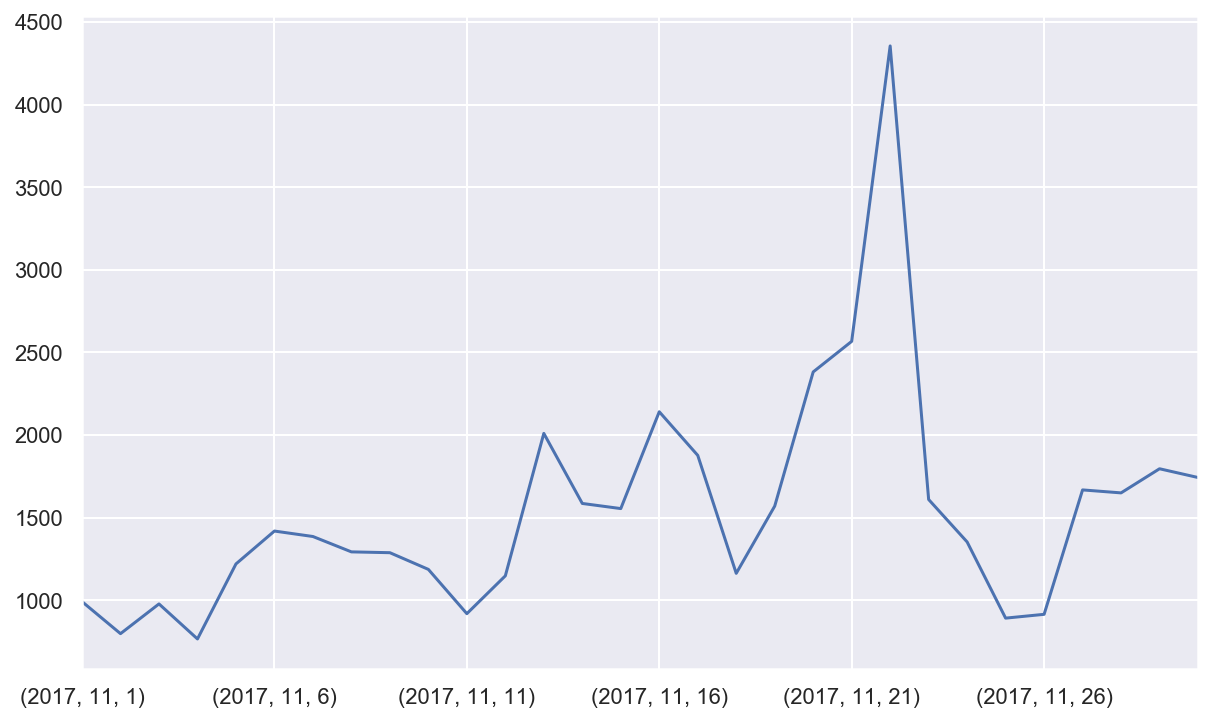

In [38]:
students_sessions[students_sessions["CourseName"]=="Direito"].SessionStartTime.apply(lambda x: x[:3]).value_counts().sort_index().plot()

In [39]:
lista_reg = []
lista_reg.append(students_sessions[students_sessions['CourseName'] == "Direito"].RegisteredDate.apply(lambda x: x[:2]).value_counts().sort_index())
lista_reg.append(students_sessions[students_sessions['CourseName'] == "Administração"].RegisteredDate.apply(lambda x: x[:2]).value_counts().sort_index())
lista_reg.append(students_sessions[students_sessions['CourseName'] == "Engenharia Civil"].RegisteredDate.apply(lambda x: x[:2]).value_counts().sort_index())
lista_reg.append(students_sessions[students_sessions['CourseName'] == "Contabilidade / Ciências Contábeis"].RegisteredDate.apply(lambda x: x[:2]).value_counts().sort_index())
lista_reg.append(students_sessions[students_sessions['CourseName'] == "Pedagogia"].RegisteredDate.apply(lambda x: x[:2]).value_counts().sort_index())
lista_reg.append(students_sessions[students_sessions['CourseName'] == "Psicologia"].RegisteredDate.apply(lambda x: x[:2]).value_counts().sort_index())
lista_reg.append(students_sessions[students_sessions['CourseName'] == "Enfermagem"].RegisteredDate.apply(lambda x: x[:2]).value_counts().sort_index())
lista_reg.append(students_sessions[students_sessions['CourseName'] == "Medicina"].RegisteredDate.apply(lambda x: x[:2]).value_counts().sort_index())

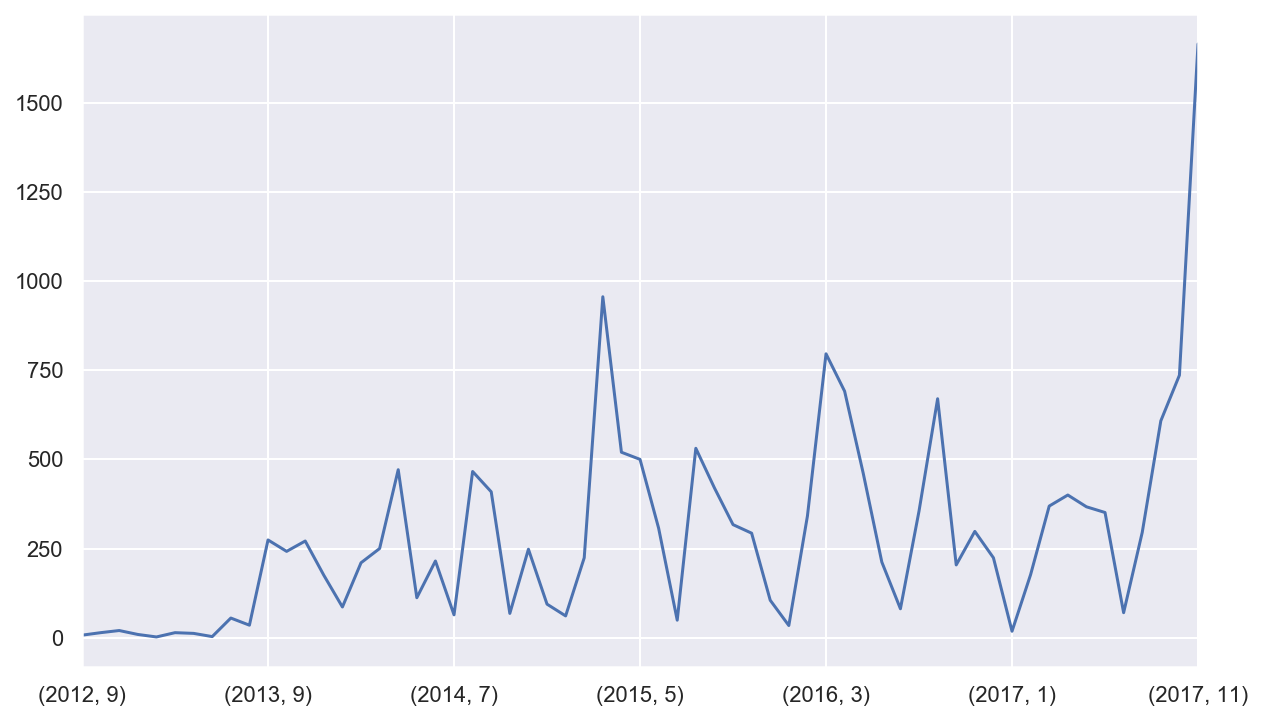

In [40]:
lista_reg[2].plot()

In [41]:
lista_ses = []
lista_ses.append(students_sessions[students_sessions['CourseName'] == "Direito"].SessionStartTime.apply(lambda x: x[:3]).value_counts().sort_index())
lista_ses.append(students_sessions[students_sessions['CourseName'] == "Administração"].SessionStartTime.apply(lambda x: x[:3]).value_counts().sort_index())
lista_ses.append(students_sessions[students_sessions['CourseName'] == "Engenharia Civil"].SessionStartTime.apply(lambda x: x[:3]).value_counts().sort_index())
lista_ses.append(students_sessions[students_sessions['CourseName'] == "Contabilidade / Ciências Contábeis"].SessionStartTime.apply(lambda x: x[:3]).value_counts().sort_index())
lista_ses.append(students_sessions[students_sessions['CourseName'] == "Pedagogia"].SessionStartTime.apply(lambda x: x[:3]).value_counts().sort_index())
lista_ses.append(students_sessions[students_sessions['CourseName'] == "Psicologia"].SessionStartTime.apply(lambda x: x[:3]).value_counts().sort_index())
lista_ses.append(students_sessions[students_sessions['CourseName'] == "Enfermagem"].SessionStartTime.apply(lambda x: x[:3]).value_counts().sort_index())
lista_ses.append(students_sessions[students_sessions['CourseName'] == "Medicina"].SessionStartTime.apply(lambda x: x[:3]).value_counts().sort_index())

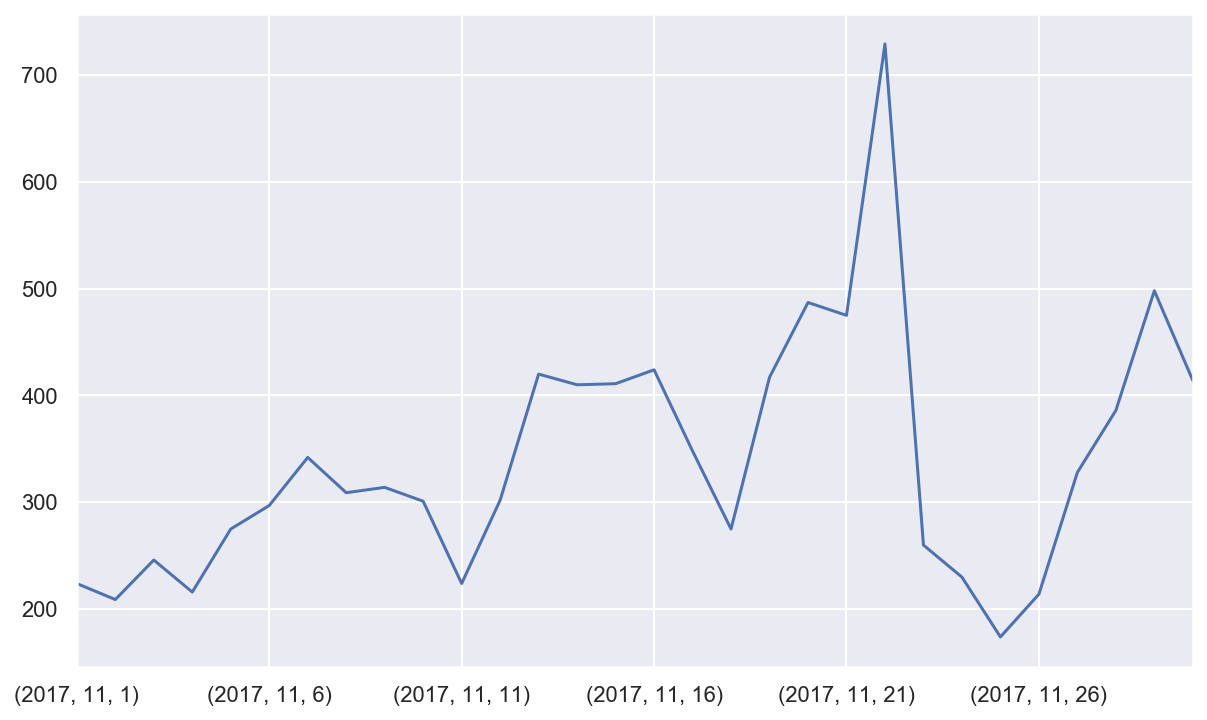

In [42]:
lista_ses[6].plot()

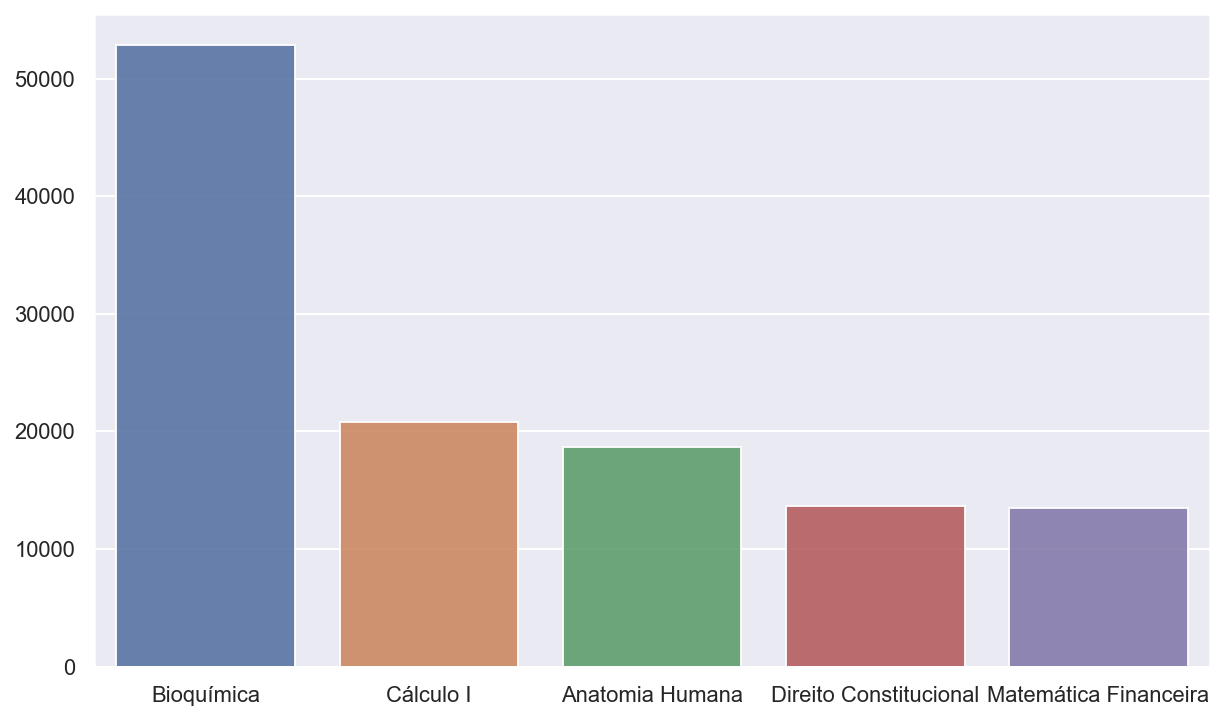

In [45]:
sns.barplot(students_subjects.SubjectName.value_counts().head(5).index, students_subjects.CourseName.value_counts().head(5).values, alpha=0.9)

In [244]:

log_data = np.log(data)
pd.plotting.scatter_matrix(log_data, alpha = 0.3, figsize = (14,8), diagonal = 'kde');

[(2012, 6),
 (2012, 7),
 (2012, 8),
 (2012, 9),
 (2012, 10),
 (2012, 11),
 (2012, 12),
 (2013, 1),
 (2013, 2),
 (2013, 3),
 (2013, 4),
 (2013, 5),
 (2013, 6),
 (2013, 7),
 (2013, 8),
 (2013, 9),
 (2013, 10),
 (2013, 11),
 (2013, 12),
 (2014, 1),
 (2014, 2),
 (2014, 3),
 (2014, 4),
 (2014, 5),
 (2014, 6),
 (2014, 7),
 (2014, 8),
 (2014, 9),
 (2014, 10),
 (2014, 11),
 (2014, 12),
 (2015, 1),
 (2015, 2),
 (2015, 3),
 (2015, 4),
 (2015, 5),
 (2015, 6),
 (2015, 7),
 (2015, 8),
 (2015, 9),
 (2015, 10),
 (2015, 11),
 (2015, 12),
 (2016, 1),
 (2016, 2),
 (2016, 3),
 (2016, 4),
 (2016, 5),
 (2016, 6),
 (2016, 7),
 (2016, 8),
 (2016, 9),
 (2016, 10),
 (2016, 11),
 (2016, 12),
 (2017, 1),
 (2017, 2),
 (2017, 3),
 (2017, 4),
 (2017, 5),
 (2017, 6),
 (2017, 7),
 (2017, 8),
 (2017, 9),
 (2017, 10),
 (2017, 11)]

In [164]:
students_subjects.RegisteredDate.value_counts()

AttributeError: 'Series' object has no attribute 'sort'

In [142]:
sns.barplot(students_subjects.set_index('RegisteredDate').loc[a].index, students_subjects.set_index('RegisteredDate').loc[a].values, alpha=0.9)

/Users/vml/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  """Entry point for launching an IPython kernel.


AttributeError: 'DataFrame' object has no attribute 'RegisteredDate'

In [130]:
a[:5]

[(2012, 6, 3), (2012, 6, 7), (2012, 6, 8), (2012, 6, 13), (2012, 6, 17)]

In [46]:
# fazer do úlitmo mês, ou dos últimos 6 meses desde a última data
state_geo = 'https://raw.githubusercontent.com/luizpedone/municipal-brazilian-geodata/master/data/Brasil.json'
state_data = students_sessions[["State","RegisteredDate"]].State.value_counts().reset_index().rename(columns={"index":"ESTADO", "State":"Usuários registrados"})
state_data["Usuários registrados"] = state_data["Usuários registrados"].apply(lambda x: 100*x/state_data["Usuários registrados"].sum())

In [73]:
m = folium.Map(location=[-14, -50], zoom_start=4.4)

folium.Choropleth(
    geo_data=state_geo,
    name='choropleth',
    data=state_data,
    columns=['ESTADO','Usuários registrados'],
    key_on='feature.properties.ESTADO',
    fill_color='YlOrRd',
    fill_opacity=0.5,
    line_opacity=0.5,
    legend_name='Taxa de Registrados em um ano'
).add_to(m)

folium.LayerControl().add_to(m)

m

In [77]:
# Se quiser salvar em HTML, só executar essa parte
folium.LayerControl(collapsed=False).add_to(m)
time_string = time.asctime().replace(" ", "_")
time_string = time_string[20:24] +"_"+ time_string[4:7] +"_"+ time_string[8:10]
m.save(f'taxa_br_{time_string}.html')

In [72]:
# Load data
df= pd.DataFrame(lista_ses[0]).reset_index().rename(columns = {"index":"SessionStartTime","SessionStartTime":"Volume"});
df["SessionStartTime"] = df["SessionStartTime"].apply(lambda x : str(x[0])+"-"+str(x[1])+"-"+str(x[2]))

# Create figure
fig = go.Figure()

fig.add_trace(
    go.Scatter(x=list(df.SessionStartTime), y=list(df.Volume)))

# Set title
fig.update_layout(
    title_text="Time series with range slider and selectors"
)

# Add range slider
fig.update_layout(
    xaxis=go.layout.XAxis(
        rangeselector=dict(
            buttons=list([
                dict(count=1,
                     label="1m",
                     step="month",
                     stepmode="backward"),
                dict(count=6,
                     label="6m",
                     step="month",
                     stepmode="backward"),
                dict(count=1,
                     label="YTD",
                     step="year",
                     stepmode="todate"),
                dict(count=1,
                     label="1y",
                     step="year",
                     stepmode="backward"),
                dict(step="all")
            ])
        ),
        rangeslider=dict(
            visible=True
        ),
        type="date"
    )
)
fig.show()

In [74]:
# Create figure
fig = go.Figure()

# Add traces
fig.add_trace(go.Scatter(
    x=["2013-01-15", "2013-01-29", "2013-02-26", "2013-04-19", "2013-07-02",
       "2013-08-27",
       "2013-10-22", "2014-01-20", "2014-05-05", "2014-07-01", "2015-02-09",
       "2015-04-13",
       "2015-05-13", "2015-06-08", "2015-08-05", "2016-02-25"],
    y=["8", "3", "2", "10", "5", "5", "6", "8", "3", "3", "7", "5", "10", "10", "9",
       "14"],
    name="var0",
    text=["8", "3", "2", "10", "5", "5", "6", "8", "3", "3", "7", "5", "10", "10", "9",
          "14"],
    yaxis="y",
))

fig.add_trace(go.Scatter(
    x=["2015-04-13", "2015-05-13", "2015-06-08", "2015-08-05", "2016-02-25"],
    y=["53.0", "69.0", "89.0", "41.0", "41.0"],
    name="var1",
    text=["53.0", "69.0", "89.0", "41.0", "41.0"],
    yaxis="y2",
))

fig.add_trace(go.Scatter(
    x=["2013-01-29", "2013-02-26", "2013-04-19", "2013-07-02", "2013-08-27",
       "2013-10-22",
       "2014-01-20", "2014-04-09", "2014-05-05", "2014-07-01", "2014-09-30",
       "2015-02-09",
       "2015-04-13", "2015-06-08", "2016-02-25"],
    y=["9.6", "4.6", "2.7", "8.3", "18", "7.3", "3", "7.5", "1.0", "0.5", "2.8", "9.2",
       "13", "5.8", "6.9"],
    name="var2",
    text=["9.6", "4.6", "2.7", "8.3", "18", "7.3", "3", "7.5", "1.0", "0.5", "2.8",
          "9.2",
          "13", "5.8", "6.9"],
    yaxis="y3",
))

fig.add_trace(go.Scatter(
    x=["2013-01-29", "2013-02-26", "2013-04-19", "2013-07-02", "2013-08-27",
       "2013-10-22",
       "2014-01-20", "2014-04-09", "2014-05-05", "2014-07-01", "2014-09-30",
       "2015-02-09",
       "2015-04-13", "2015-06-08", "2016-02-25"],
    y=["6.9", "7.5", "7.3", "7.3", "6.9", "7.1", "8", "7.8", "7.4", "7.9", "7.9", "7.6",
       "7.2", "7.2", "8.0"],
    name="var3",
    text=["6.9", "7.5", "7.3", "7.3", "6.9", "7.1", "8", "7.8", "7.4", "7.9", "7.9",
          "7.6",
          "7.2", "7.2", "8.0"],
    yaxis="y4",
))

fig.add_trace(go.Scatter(
    x=["2013-02-26", "2013-07-02", "2013-09-26", "2013-10-22", "2013-12-04",
       "2014-01-02",
       "2014-01-20", "2014-05-05", "2014-07-01", "2015-02-09", "2015-05-05"],
    y=["290", "1078", "263", "407", "660", "740", "33", "374", "95", "734", "3000"],
    name="var4",
    text=["290", "1078", "263", "407", "660", "740", "33", "374", "95", "734", "3000"],
    yaxis="y5",
))

# style all the traces
fig.update_traces(
    hoverinfo="name+x+text",
    line={"width": 0.5},
    marker={"size": 8},
    mode="lines+markers",
    showlegend=False
)

# Add annotations
fig.update_layout(
    annotations=[
        go.layout.Annotation(
            x="2013-06-01",
            y=0,
            arrowcolor="rgba(63, 81, 181, 0.2)",
            arrowsize=0.3,
            ax=0,
            ay=30,
            text="state1",
            xref="x",
            yanchor="bottom",
            yref="y"
        ),
        go.layout.Annotation(
            x="2014-09-13",
            y=0,
            arrowcolor="rgba(76, 175, 80, 0.1)",
            arrowsize=0.3,
            ax=0,
            ay=30,
            text="state2",
            xref="x",
            yanchor="bottom",
            yref="y"
        )
    ],
)

# Add shapes
fig.update_layout(
    shapes=[
        go.layout.Shape(
            fillcolor="rgba(63, 81, 181, 0.2)",
            line={"width": 0},
            type="rect",
            x0="2013-01-15",
            x1="2013-10-17",
            xref="x",
            y0=0,
            y1=0.95,
            yref="paper"
        ),
        go.layout.Shape(
            fillcolor="rgba(76, 175, 80, 0.1)",
            line={"width": 0},
            type="rect",
            x0="2013-10-22",
            x1="2015-08-05",
            xref="x",
            y0=0,
            y1=0.95,
            yref="paper"
        )
    ]
)

# Update axes
fig.update_layout(
    xaxis=go.layout.XAxis(
        autorange=True,
        range=["2012-10-31 18:36:37.3129", "2016-05-10 05:23:22.6871"],
        rangeslider=dict(
            autorange=True,
            range=["2012-10-31 18:36:37.3129", "2016-05-10 05:23:22.6871"]
        ),
        type="date"
    ),
    yaxis=go.layout.YAxis(
        anchor="x",
        autorange=True,
        domain=[0, 0.2],
        linecolor="#673ab7",
        mirror=True,
        range=[-60.0858369099, 28.4406294707],
        showline=True,
        side="right",
        tickfont={"color": "#673ab7"},
        tickmode="auto",
        ticks="",
        titlefont={"color": "#673ab7"},
        type="linear",
        zeroline=False
    ),
    yaxis2=go.layout.YAxis(
        anchor="x",
        autorange=True,
        domain=[0.2, 0.4],
        linecolor="#E91E63",
        mirror=True,
        range=[29.3787777032, 100.621222297],
        showline=True,
        side="right",
        tickfont={"color": "#E91E63"},
        tickmode="auto",
        ticks="",
        titlefont={"color": "#E91E63"},
        type="linear",
        zeroline=False
    ),
    yaxis3=go.layout.YAxis(
        anchor="x",
        autorange=True,
        domain=[0.4, 0.6],
        linecolor="#795548",
        mirror=True,
        range=[-3.73690396239, 22.2369039624],
        showline=True,
        side="right",
        tickfont={"color": "#795548"},
        tickmode="auto",
        ticks="",
        title="mg/L",
        titlefont={"color": "#795548"},
        type="linear",
        zeroline=False
    ),
    yaxis4=go.layout.YAxis(
        anchor="x",
        autorange=True,
        domain=[0.6, 0.8],
        linecolor="#607d8b",
        mirror=True,
        range=[6.63368032236, 8.26631967764],
        showline=True,
        side="right",
        tickfont={"color": "#607d8b"},
        tickmode="auto",
        ticks="",
        title="mmol/L",
        titlefont={"color": "#607d8b"},
        type="linear",
        zeroline=False
    ),
    yaxis5=go.layout.YAxis(
        anchor="x",
        autorange=True,
        domain=[0.8, 1],
        linecolor="#2196F3",
        mirror=True,
        range=[-685.336803224, 3718.33680322],
        showline=True,
        side="right",
        tickfont={"color": "#2196F3"},
        tickmode="auto",
        ticks="",
        title="mg/Kg",
        titlefont={"color": "#2196F3"},
        type="linear",
        zeroline=False
    )
)

# Update layout
fig.update_layout(
    dragmode="zoom",
    hovermode="x",
    legend=dict(traceorder="reversed"),
    height=600,
    template="plotly_white",
    margin=dict(
        t=100,
        b=100
    ),
)

fig.show()

In [ ]:
# Load data
df= pd.DataFrame(lista_ses[0]).reset_index().rename(columns = {"index":"SessionStartTime","SessionStartTime":"Volume"});
df["SessionStartTime"] = df["SessionStartTime"].apply(lambda x : str(x[0])+"-"+str(x[1])+"-"+str(x[2]))

# Create figure
fig = go.Figure()

fig.add_trace(
    go.Scatter(x=list(df.SessionStartTime), y=list(df.Volume)))

# Set title
fig.update_layout(
    title_text="Time series with range slider and selectors"
)

# Add range slider
fig.update_layout(
    xaxis=go.layout.XAxis(
        rangeselector=dict(
            buttons=list([
                dict(count=1,
                     label="1m",
                     step="month",
                     stepmode="backward"),
                dict(count=6,
                     label="6m",
                     step="month",
                     stepmode="backward"),
                dict(count=1,
                     label="YTD",
                     step="year",
                     stepmode="todate"),
                dict(count=1,
                     label="1y",
                     step="year",
                     stepmode="backward"),
                dict(step="all")
            ])
        ),
        rangeslider=dict(
            visible=True
        ),
        type="date"
    )
)
fig.show()

In [75]:
students_subjects

,StudentId,CourseName,UniversityName,RegisteredDate,State,City,SubjectName,FollowDate,StudentClient,SignupSource
0,0cade9bf00234e3789afc76250e4042bc1b70784ae7004...,Engenharia Elétrica,UERJ,"(2012, 9, 6, 17, 27, 11)",Rio de Janeiro,Rio de Janeiro,Eletrônica II,"(2015, 9, 7, 15, 49, 12)",NaN,Facebook
1,0cade9bf00234e3789afc76250e4042bc1b70784ae7004...,Engenharia Elétrica,UERJ,"(2012, 9, 6, 17, 27, 11)",Rio de Janeiro,Rio de Janeiro,Circuitos Elétricos II,"(2015, 9, 7, 15, 49, 12)",NaN,Facebook
2,0cade9bf00234e3789afc76250e4042bc1b70784ae7004...,Engenharia Elétrica,UERJ,"(2012, 9, 6, 17, 27, 11)",Rio de Janeiro,Rio de Janeiro,Eletrônica,"(2015, 9, 7, 15, 49, 12)",NaN,Facebook
3,0cade9bf00234e3789afc76250e4042bc1b70784ae7004...,Engenharia Elétrica,UERJ,"(2012, 9, 6, 17, 27, 11)",Rio de Janeiro,Rio de Janeiro,Circuitos II,"(2015, 9, 7, 15, 49, 12)",NaN,Facebook
4,0cade9bf00234e3789afc76250e4042bc1b70784ae7004...,Engenharia Elétrica,UERJ,"(2012, 9, 6, 17, 27, 11)",Rio de Janeiro,Rio de Janeiro,Circuitos Elétricos e Eletrônicos 2,"(2015, 9, 7, 15, 49, 12)",NaN,Facebook
5,8a501cab6c0a5a7e98a86f51a6264d81cdb562f4e99106...,Economia / Ciências Econômicas,UERJ,"(2012, 9, 5, 15, 31, 8)",Rio de Janeiro,Rio de Janeiro,Teoria Microeconômica I,"(2015, 12, 7, 16, 17, 54)",NaN,Facebook
6,8a501cab6c0a5a7e98a86f51a6264d81cdb562f4e99106...,Economia / Ciências Econômicas,UERJ,"(2012, 9, 5, 15, 31, 8)",Rio de Janeiro,Rio de Janeiro,Econometria I,"(2015, 12, 7, 16, 17, 54)",NaN,Facebook
7,8a501cab6c0a5a7e98a86f51a6264d81cdb562f4e99106...,Economia / Ciências Econômicas,UERJ,"(2012, 9, 5, 15, 31, 8)",Rio de Janeiro,Rio de Janeiro,Microeconomia 2,"(2015, 12, 7, 16, 17, 54)",NaN,Facebook
8,8a501cab6c0a5a7e98a86f51a6264d81cdb562f4e99106...,Economia / Ciências Econômicas,UERJ,"(2012, 9, 5, 15, 31, 8)",Rio de Janeiro,Rio de Janeiro,Microeconomia 1,"(2015, 12, 7, 16, 17, 54)",NaN,Facebook
9,8a501cab6c0a5a7e98a86f51a6264d81cdb562f4e99106...,Economia / Ciências Econômicas,UERJ,"(2012, 9, 5, 15, 31, 8)",Rio de Janeiro,Rio de Janeiro,Métodos Quantitativos em Economia I,"(2015, 12, 7, 16, 17, 54)",NaN,Facebook
